# SuSiE Purity Plot

This is mostly the same as `20180516_Purity_Plot.ipynb` but using `lm_less` simulation model instead of `simple_lm`. The difference is that now PVE is confined to 0.2. 

In [4]:
%revisions -n 10 --source

In [3]:
%cd ~/GIT/github/mvarbvs/dsc

/project/mstephens/SuSiE/mvarbvs/dsc

Other differences include:

1. Increase number of genes to 100 and use 2 replicates per analysis
2. Fix a minor bug in residual variance simulation
3. Use $|r|$ for LD filtering, not $r^2$
4. **Add histogram of purity**

Therefore I chose an LD cutoff of 0.5 for now (comparable to 0.25 when squared). But we argue that in practice it does not matter.

## Results

### Purity plots

Purity plots updated to [here](http://shiny.stephenslab.uchicago.edu/gaow/purity_20180620). In particular we focus on this one with 2 causal, prior 0.1 for PVE 0.2, and `null_weight` set to 0.5.

> susie_comparison/purity_20180620/12.png (338.4 KiB):

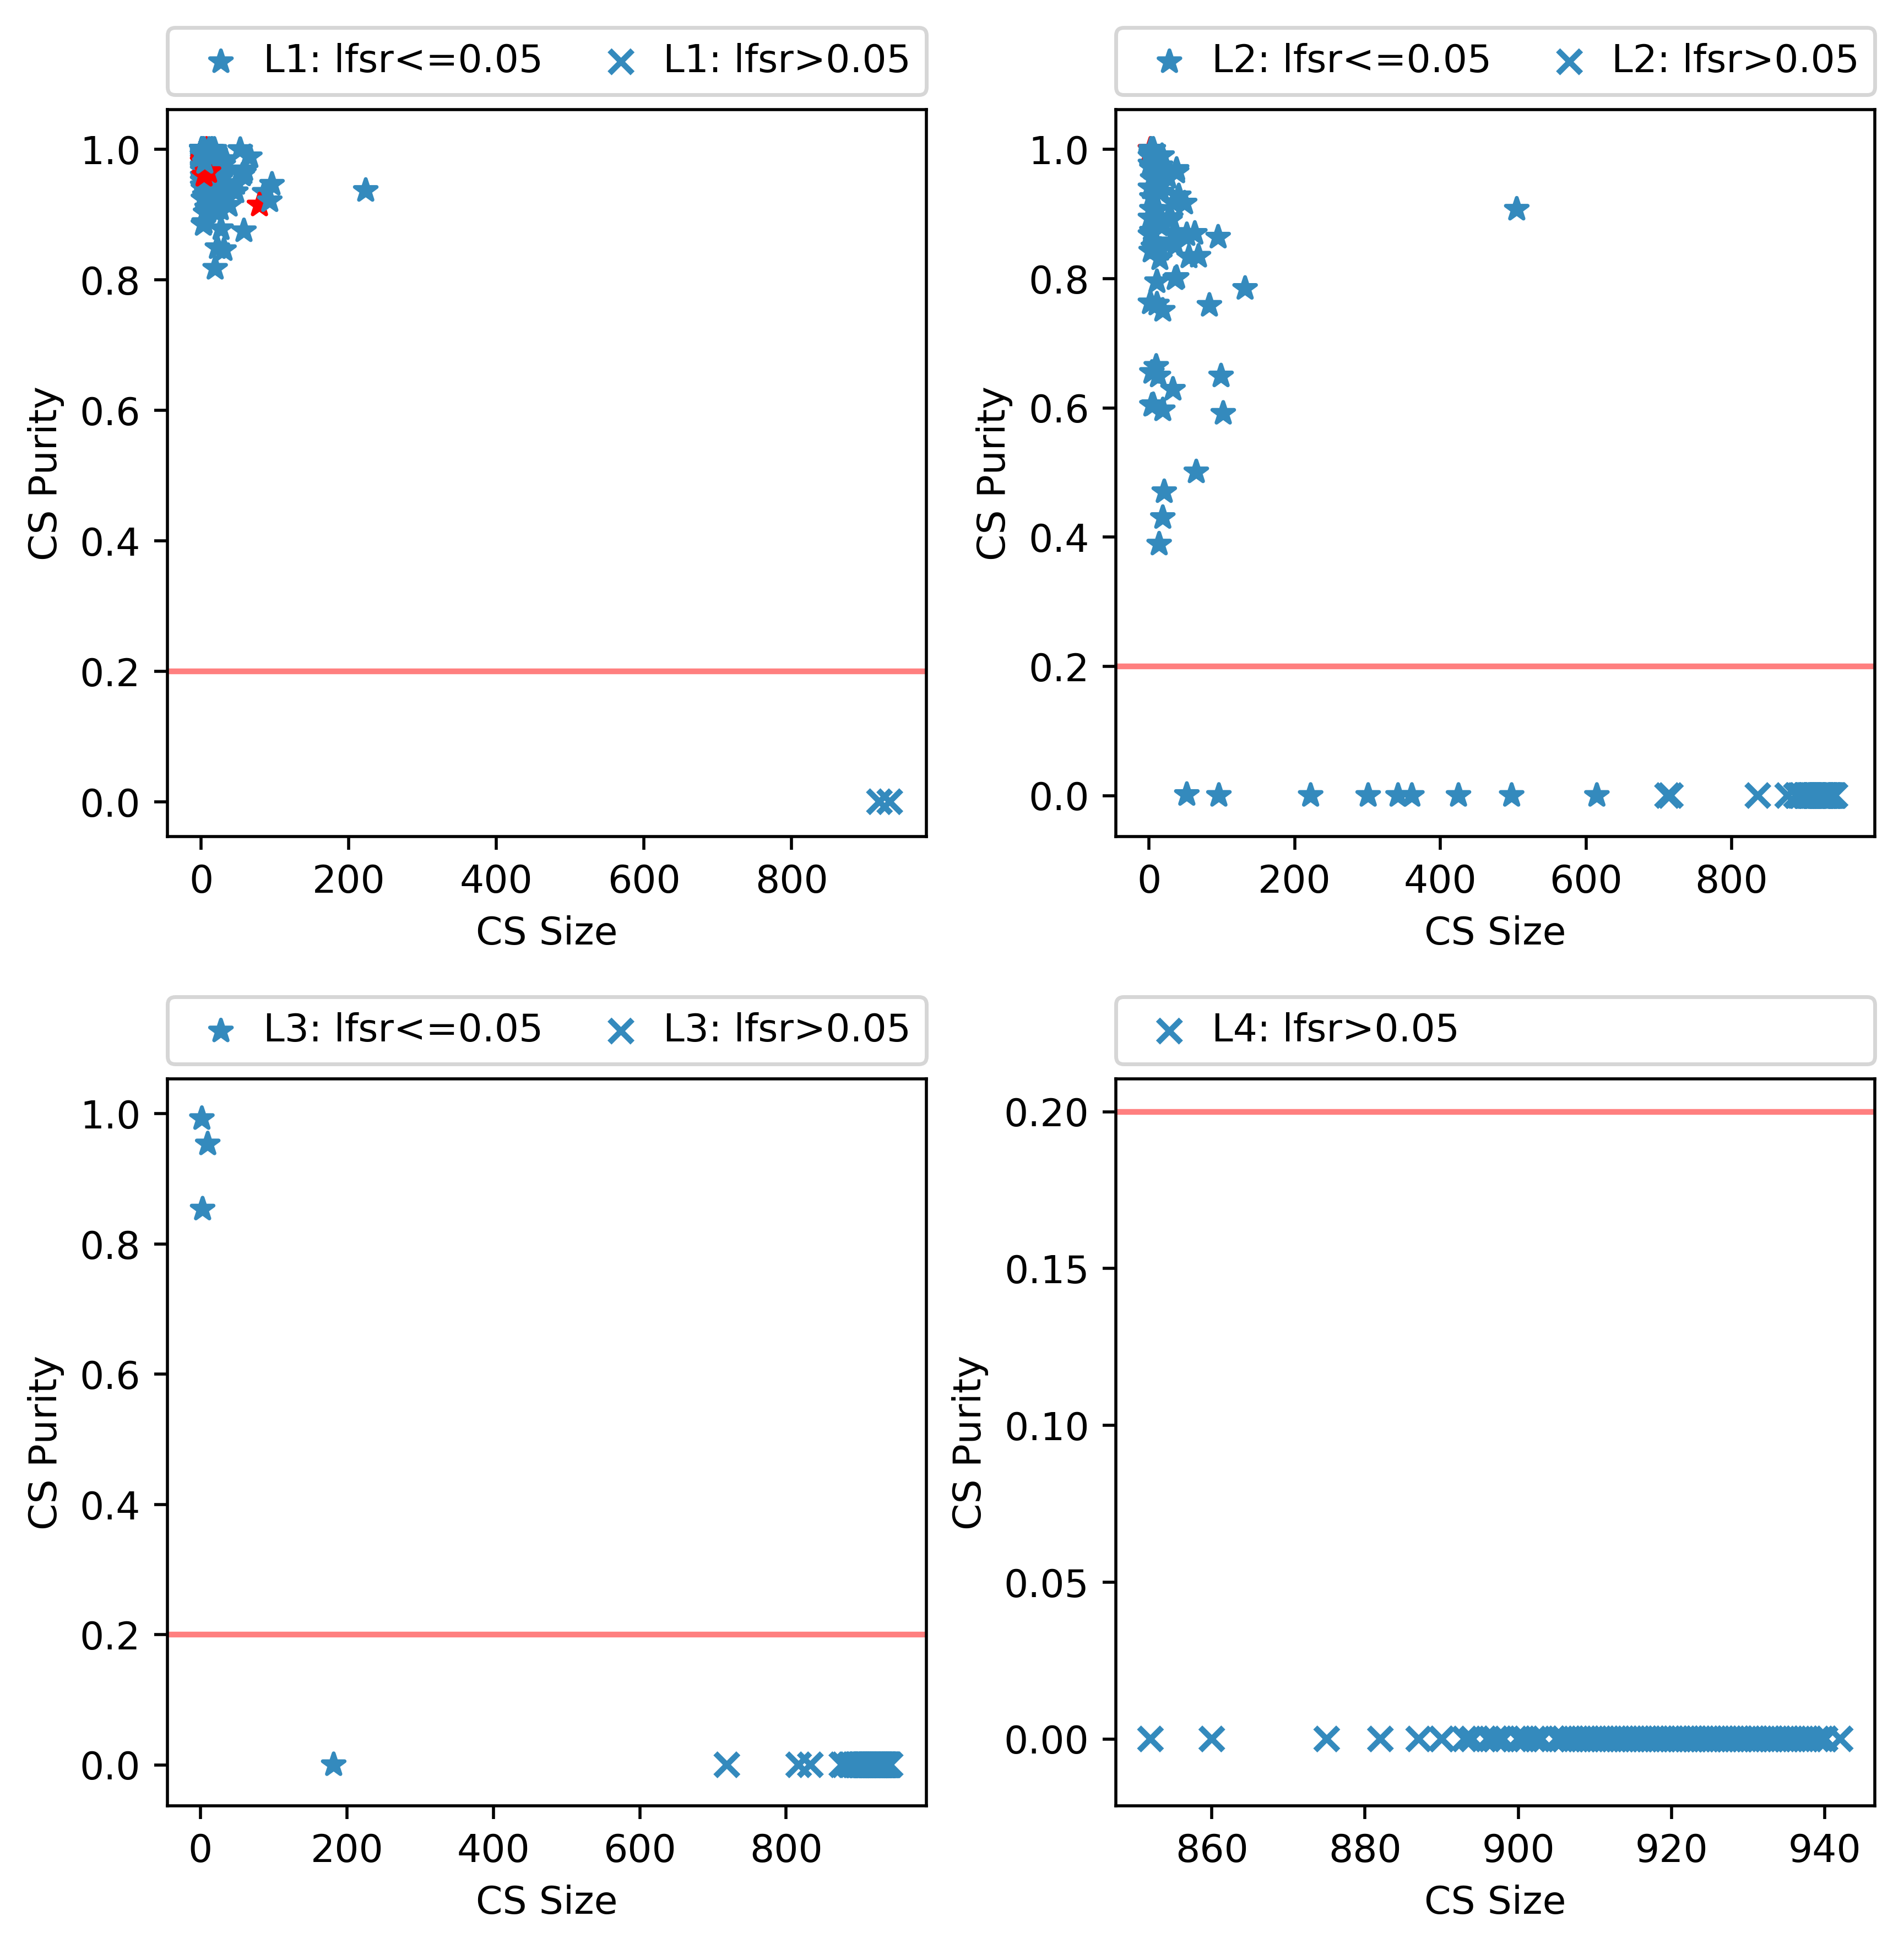

In [3]:
%preview susie_comparison/purity_20180620/12.png

### Purity filter vs capture rate

> susie_comparison/ld_20180620.png (93.0 KiB):

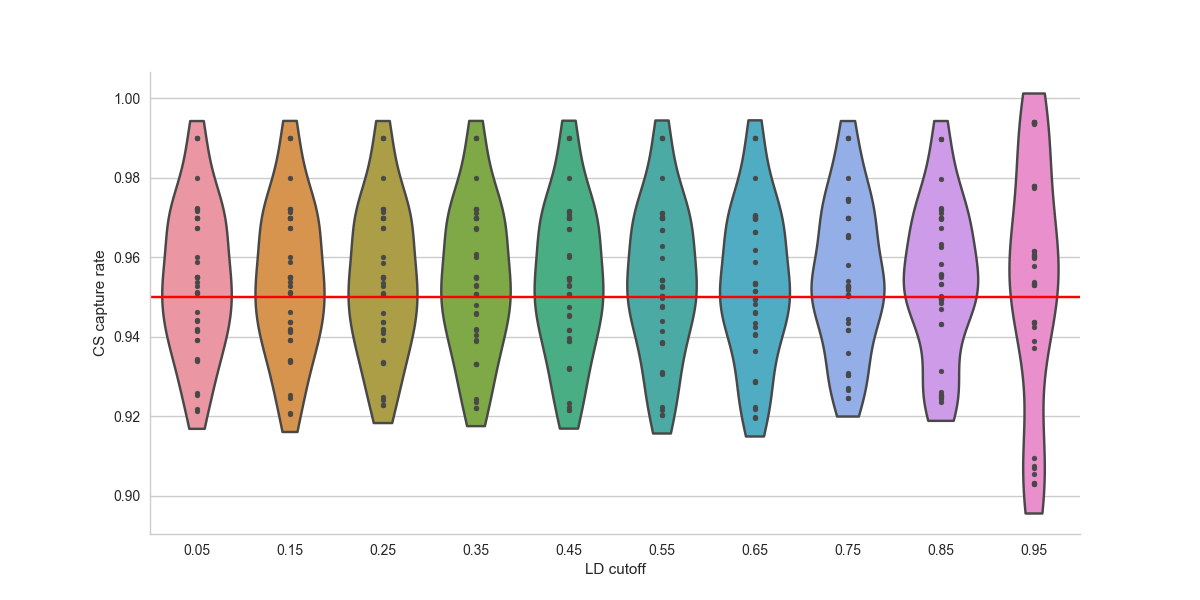

In [4]:
%preview susie_comparison/ld_20180620.png

### Histogram of purity

%preview susie_comparison/hist_0722.png

> susie_comparison/hist_0722.png (13.4 KiB):

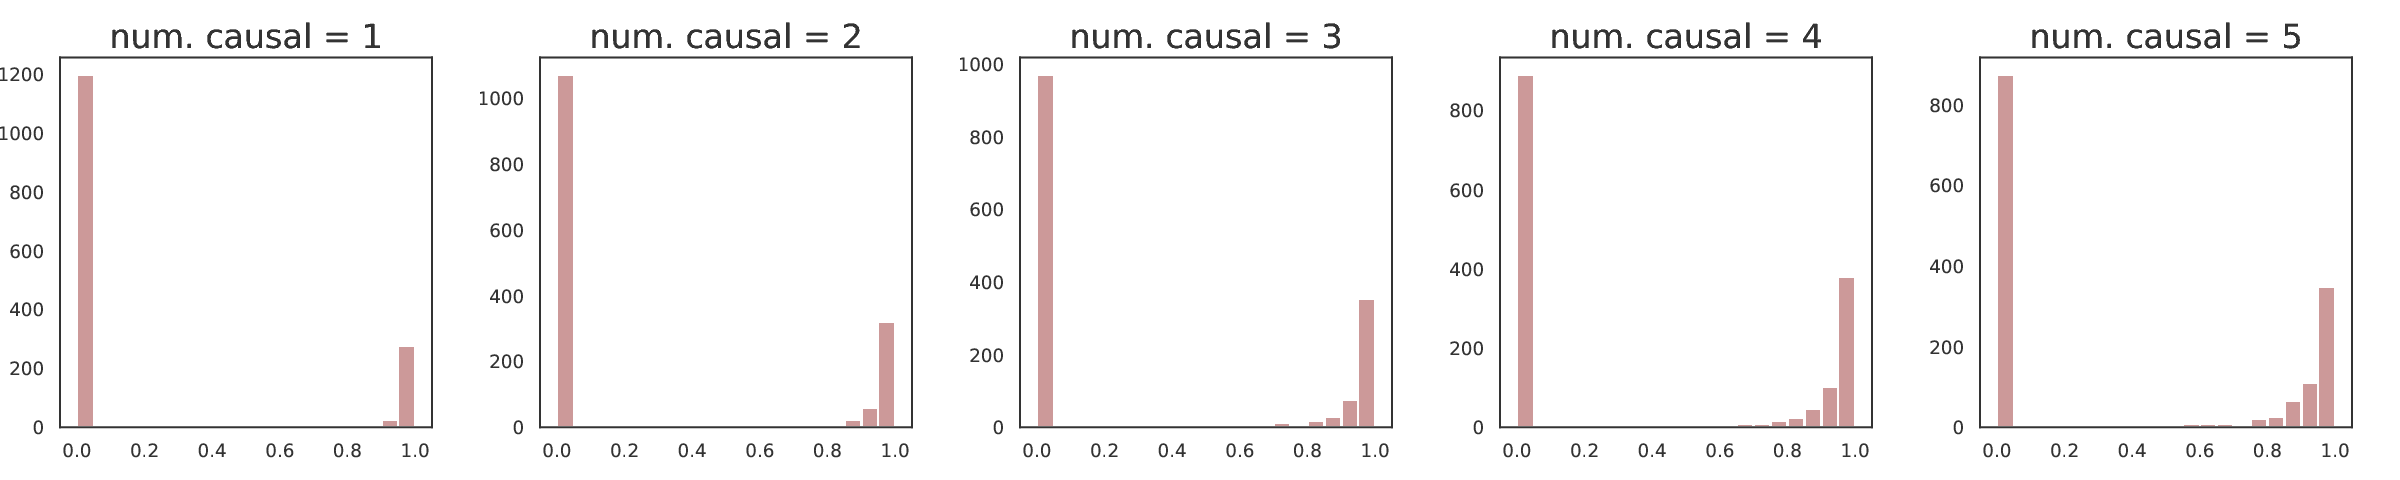

In [5]:
%preview susie_comparison/hist_0722.png

## Run benchmark

In [ ]:
dsc susie.dsc --target susie_comparison

In [ ]:
[global]
parameter: cwd = path('./')
parameter: outdir = 'susie_comparison'
parameter: name = '1008'
parameter: source = "liter_data"
parameter: dataset = 'lm_less'
parameter: susie = "fit_susie"
parameter: null_weight = [0.0,0.5,0.9,0.95]
parameter: maxL=10
ld_cutoff = 0.25
lfsr_cutoff = 0.05

## Plot by purity

In [ ]:
[purity_1, ld_1]
output: f'{cwd}/{outdir}/purity_{name}_{source}_{dataset}_{susie}.rds'
R: expand = '${ }', workdir = cwd
    out = dscrutils::dscquery("${outdir}", targets =  c("${source}.dataset","${dataset}.pve", "${dataset}.n_signal", "${susie}.maxL", "${susie}.null_weight", "${susie}.prior_var", "${susie}", "${dataset}"), 
                  module.output.files=c("${susie}", "${dataset}"))
    saveRDS(out, ${_output:r})

In [ ]:
[purity_2, ld_2]
parameter: pve = [0.2]
parameter: L = [1,2,3,4,5]
parameter: prior = [0, 0.1, 0.4]
ld_col = 1
combos = len(pve) * len(L) * len(null_weight) * len(prior)
output_files = [f'{_input:d}/{x+1}.rds' for x in range(combos)]
input: for_each = ['pve', 'L', 'null_weight', 'prior'], concurrent = True
output: output_files[_index]
R: expand = '${ }', workdir = cwd
    options(warn=2)
    get_combined = function(sub, dirname, ld_col) {
        out_files = sub[,c("${susie}.output.file", "${dataset}.output.file")]
        combined = list(purity = NULL, lfsr = NULL, size = NULL, 
                        captures = NULL, total_captures = NULL)
        for (i in 1:nrow(out_files)) {
            fit_file = paste0(dirname, out_files[i,1], '.rds')
            dat = readRDS(fit_file)$fit
            truth = dscrutils:::read_dsc(paste0(dirname, out_files[i,2]))$data$true_coef
            L = sub[i,"${dataset}.n_signal"]
            for (r in 1:2) {
                signals = which(truth[,r]!=0)
                if (is.null(dat[[r]]$sets$cs)) next
                purity_r = as.matrix(dat[[r]]$sets$purity)
                dm = dim(purity_r)
                if (dm[1] < ${maxL}) {
                    purity_r = rbind(purity_r, matrix(0, ${maxL}-dm[1], dm[2]))
                }
                if (is.null(combined$purity)) combined$purity = purity_r[,ld_col]
                else combined$purity = cbind(combined$purity, purity_r[,ld_col])
                #
                if (is.null(combined$size)) combined$size = susieR:::n_in_CS(dat[[r]])
                else combined$size = cbind(combined$size, susieR:::n_in_CS(dat[[r]]))
                #
                if (is.null(combined$lfsr)) combined$lfsr = susieR::susie_get_lfsr(dat[[r]])
                else combined$lfsr = cbind(combined$lfsr, susieR::susie_get_lfsr(dat[[r]]))
                #
                capture_status = unlist(lapply(1:length(dat[[r]]$sets$cs), function(i) sum(dat[[r]]$sets$cs[[i]] %in% signals)))
                if (length(capture_status) < ${maxL})
                  capture_status = c(capture_status, rep(L, ${maxL} - length(capture_status)))
                if (is.null(combined$captures)) combined$captures = capture_status
                else combined$captures = cbind(combined$captures, capture_status)
                #
                detected = colSums(do.call(rbind, lapply(1:length(dat[[r]]$sets$cs), function(i) signals %in% dat[[r]]$sets$cs[[i]])))
                if (length(detected) < L) {
                  detected = c(detected, rep(0, L - length(detected)))
                }
                if (is.null(combined$total_captures)) combined$total_captures = detected
                else combined$total_captures = combined$total_captures + detected      
            }
        }
        return(combined)
    }
    out = readRDS(${_input:r})
    sub = out[which(out$${dataset}.pve == ${_pve} & out$${dataset}.n_signal == ${_L} & out$${susie}.null_weight == ${_null_weight} & out$${susie}.prior_var == ${_prior}),]
    combined = get_combined(sub, "${outdir}/", ${ld_col})
    write(paste(${_pve}, ${_L}, ${_prior}, ${_null_weight}, "${_output:n}.png", sep=','), file='${_output:n}.log')
    saveRDS(combined, ${_output:r})

In [ ]:
[purity_3, ld_3]
output: f"{_input:n}.pkl"
bash: expand = True, workdir = cwd
  dsc-io {_input} {_output}

In [ ]:
[purity_4]
output: f"{_input:n}.pdf"
python: expand = '${ }', workdir = cwd
    import numpy as np
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt
    COLORS = ['#348ABD', '#7A68A6', '#A60628', '#467821', '#FF0000', '#188487', '#E2A233',
                  '#A9A9A9', '#000000', '#FF00FF', '#FFD700', '#ADFF2F', '#00FFFF']
    color_mapper = np.vectorize(lambda x: dict([(i,j) for i,j in enumerate(COLORS)]).get(x))

    def plot_purity(data, output, lfsr_cutoff = 0.05, verbose = False, delta_l = 2):
        purity = np.array(data['purity'])
        lfsr = np.array(data['lfsr'])
        size = np.array(data['size'])
        capture = np.array(data['captures'])
        capture_summary = [f"Signal {idx+1} captured {int(item)}/{purity.shape[1]}" for idx, item in enumerate([data['total_captures']] if isinstance(data['total_captures'], np.float64) else data['total_captures'])]
        n_causal = len(capture_summary)
        idx = 0
        plt.figure(figsize=(8, 8))
        L = purity.shape[0]
        if delta_l > 0:
            L = min(n_causal + delta_l, L)
        cols = 2
        rows = L // cols + L % cols
        position = range(1,L + 1)
        insig = []
        for x, y, z, c in zip(size, purity, lfsr, capture):
            # exclude previously marked insignificant positions
            exclude = [i for i, item in enumerate(x) if (x[i], y[i]) in insig]
            z_sig = [i for i, zz in enumerate(z) if zz <= lfsr_cutoff and i not in exclude]
            z_nsig = [i for i, zz in enumerate(z) if zz > lfsr_cutoff and i not in exclude]
            colors = [4 if i == 0 else 0 for i in c]
            plt.subplot(rows,cols,position[idx])
            idx += 1
            if len(z_sig):
                label = f'L{idx}: lfsr<={lfsr_cutoff}'
                plt.scatter(np.take(x, z_sig),
                            np.take(y, z_sig),
                            c = color_mapper(np.take(colors, z_sig)), 
                            label = label, marker = '*')
            if len(z_nsig):
                label = f'L{idx}: lfsr>{lfsr_cutoff}'
                plt.scatter(np.take(x, z_nsig),
                            np.take(y, z_nsig),
                            c = color_mapper(np.take(colors, z_nsig)), 
                            label = label, marker = 'x')
            # mask colored (insig) sets
            insig.extend([(x[i], y[i]) for i, item in enumerate(colors) if item > 0 and i not in exclude])
            insig = list(set(insig))
            plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                    mode="expand", borderaxespad=0, ncol=2, handletextpad=0.1)
            plt.axhline(y=${ld_cutoff}, color = '#FF0000', alpha=0.5)
            plt.xlabel("CS Size")
            plt.ylabel("CS Purity")
            if idx >= L:
                break
        plt.subplots_adjust(hspace=0.5/3*rows, wspace = 0.25)
        if verbose:
            plt.suptitle(f"95% CI set sizes vs min(abs(LD)) | LD filter ${ld_cutoff}\n{'; '.join(capture_summary)}")
        plt.savefig(output, dpi=500, bbox_inches='tight')
        plt.gca()

    import pickle, os
    data = pickle.load(open('${_input}', 'rb'))
    try:
        plot_purity(data, '${_output}', lfsr_cutoff = ${lfsr_cutoff})
        os.system("convert -density 120 ${_output} ${_output:n}.png")
    except Exception as e:
        print(e)
        os.system("touch ${_output}")

In [ ]:
[purity_5]
header = 'PVE,N_Causal,susie_prior,null_weight,output'
input: group_by = 'all'
output:  f'{cwd}/{outdir}/purity_{name}/index.html'
bash: expand = True, workdir = cwd
    echo {header} > {_output:n}.csv
    cat {str(_input).replace('.pdf', '.log')} >> {_output:n}.csv
    cd {_output:d}
    dsc-io {_output:an}.csv {_output:a}

## Plot capture rate by purity filter

In [ ]:
[ld_4]
input: group_by = 'all'
output: f'{cwd}/{outdir}/ld_{name}.pkl'
python: expand = '${ }', workdir = cwd
    import numpy as np
    import pickle
    lds = dict([(x, []) for x in np.linspace(0, 1, num=21) if x < 1])
    for f in [${_input:r,}]:
        data = pickle.load(open(f, 'rb'))
        if data['purity'] is None:
            # failed to generate this dataset
            continue
        for k in lds:
            cs_capture_status = np.array(data['captures'][np.where(data['purity'] > k)]).ravel()
            if len(cs_capture_status):
                lds[k].append((f, sum(cs_capture_status > 0) / len(cs_capture_status)))
    with open(${_output:r}, 'wb') as f:
        pickle.dump(lds, f)

In [ ]:
[ld_5]
output: f'{_input:n}.png'
python: expand = '${ }', workdir = cwd
    import pickle
    import pandas as pd
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set(rc={'figure.figsize':(8,4), "font.size":10, "axes.titlesize":10,"axes.labelsize":10}, style = "whitegrid")
    fig, ax = plt.subplots(figsize=(8,4))
    data = pickle.load(open('${outdir}/ld_${name}.pkl', 'rb'))
    plot_data = dict([('LD cutoff', []), ('CS capture rate', [])])
    idx = 0
    for k in sorted(data.keys()):
        idx += 1
        if idx % 2:
            continue
        for item in data[k]:
            plot_data['LD cutoff'].append(f'{k:.2f}')
            plot_data['CS capture rate'].append(item[1])
    plot_data = pd.DataFrame(plot_data)
    sns.violinplot(ax=ax, x="LD cutoff", y="CS capture rate", data=plot_data, cut=0.5, inner="box")
    sns.despine()
    plt.axhline(0.95, color='red')
    ax.get_figure().savefig("${_output:n}.pdf")
    import os
    os.system("convert -density 120 ${_output:n}.pdf ${_output}")

## Histogram of purity

In [ ]:
[purity_6]
use_null_weight = 0.5
output: f'{cwd}/{outdir}/hist_{name}.png'
python: expand = '${ }', workdir = cwd
    import numpy as np
    import pandas as pd
    import pickle, os
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set(rc={'figure.figsize':(4,4), "font.size":20, "axes.titlesize":20,"axes.labelsize":20}, style = "white")
    data = pd.read_csv("${_input:n}.csv").query('null_weight == ${use_null_weight} and susie_prior == 0.1')
    files = data['output'].tolist()
    ncausal = data['N_Causal'].tolist()
    pngs = []
    for f,n in zip(files,ncausal):
        hist_dat = pickle.load(open(f[:-3] + 'pkl', 'rb'))['purity']
        fig, ax = plt.subplots(figsize=(4,4))
        sns.distplot(np.ravel(np.array(hist_dat)), ax=ax, bins=20, kde=False, color='#800000')
        sns.despine()
        ax.set_title(f'{n} effect variable{"s" if n > 1 else ""}')
        ax.get_figure().savefig(f'${_output:n}_{n}.pdf')
        os.system(f"convert -density 120 ${_output:n}_{n}.pdf ${_output:n}_{n}.png")
        pngs.append(f'${_output:n}_{n}.png')
    import os
    os.system(f'convert +append {" ".join(pngs)} ${_output}')